# Retail Sales Forecasting Project
## 📘 Project Overview

This project presents a comprehensive **Retail Sales Forecasting** solution, developed using real-world transactional data to support smarter inventory management and strategic planning. The focus was on accurately forecasting weekly sales using a mix of **statistical** and **machine learning** models.

###  Key Features

- **Time Series Aggregation:** Transformed daily transactions into weekly sales data to reduce noise and uncover macro trends.
- **Feature Engineering:** Added lag features, 3-week rolling averages, rolling standard deviations, and holiday indicators for enhanced temporal modeling.
- **Modeling Approaches:**
  - **Statistical:** ARIMA and SARIMA for baseline and seasonal analysis.
  - **Machine Learning:** Prophet (with external regressors), Random Forest, and XGBoost.
- **Hyperparameter Optimization:** Used `GridSearchCV` and `TimeSeriesSplit` for robust tuning.
- **Performance Evaluation:** Compared models using MAE, RMSE, and MAPE.
- **Deployment-Ready:** Exported the best model (Tuned XGBoost) using `joblib` for real-world integration.

>  This project reflects end-to-end data science skills in forecasting, combining exploratory analysis, feature engineering, modeling, evaluation, and deployment — aligned with the needs of retail and e-commerce analytics roles.




## 1. Import Libraries and Set Options


In [104]:
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet                                                                             # Time series forecasting model
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error     # Evaluation metrics
from sklearn.ensemble import RandomForestRegressor                                                      # Random Forest regression model
from sklearn.model_selection import TimeSeriesSplit                                                     # Cross-validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit                                       # GridSearchCV for hyperparameter tuning and TimeSeriesSplit for time series cross-validation
from statsmodels.tsa.stattools import adfuller                                                          # Statistical test for stationarity   
from statsmodels.tsa.arima.model import ARIMA                                                           # ARIMA time series model 
from statsmodels.tsa.statespace.sarimax import SARIMAX                                                  # SARIMAX for seasonal ARIMA forecasting
from xgboost import XGBRegressor                                                                        # Extreme Gradient Boosting model

import joblib                                                                                           # Model saving and loading                                                                 

pd.set_option('display.float_format', lambda x: '%.2f' % x)                     # Set display format for floats for better readability
sns.set(style="whitegrid")                                                      # Set seaborn style for consistent and clean visualizations

## 2. Load Dataset and Initial Inspection

In [105]:
# Load the dataset
df = pd.read_csv('C:/Users/hh/Desktop/Target_Retail_Sales_Forecasting.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by date
df.sort_values('Date', inplace=True)

# Preview first 5 rows
print("First 5 rows:")
display(df.head())

# Check data info and missing values
print("\nData Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
print(df.describe())

First 5 rows:


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
521,522,2023-01-01,CUST522,Male,46,Beauty,3,500,1500
179,180,2023-01-01,CUST180,Male,41,Clothing,3,300,900
558,559,2023-01-01,CUST559,Female,40,Clothing,4,300,1200
302,303,2023-01-02,CUST303,Male,19,Electronics,3,30,90
978,979,2023-01-02,CUST979,Female,19,Beauty,1,25,25



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 521 to 649
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 78.1+ KB

Missing values per column:
Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount      

## 3. Aggregate Data to Weekly Sales

We aggregate daily sales to weekly totals to reduce noise and improve forecasting.


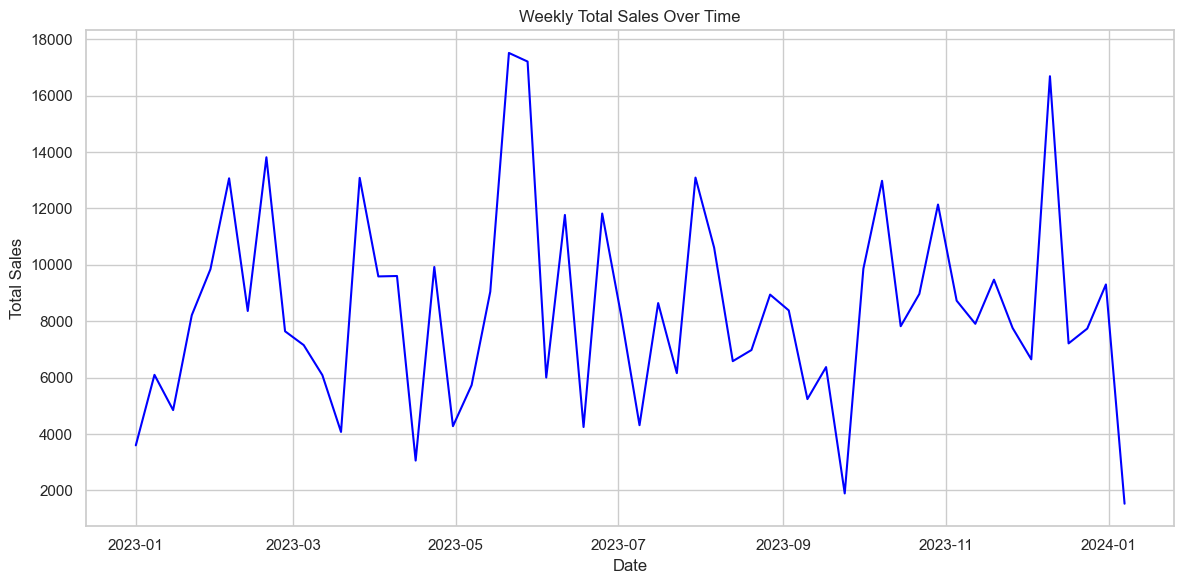

In [106]:
# Aggregate total sales by week and sort by date
weekly_df = df.groupby(pd.Grouper(key='Date', freq='W'))['Total Amount'].sum().reset_index()
weekly_df.sort_values('Date', inplace=True)

# Plot weekly total sales over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_df['Date'], weekly_df['Total Amount'], color='blue')
plt.title('Weekly Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

##  4. Time Series Sales Forecasting and Model Comparison using ARIMA and SARIMA

- **Train-Test Split for Time Series Forecasting**  
- **ARIMA Model: Training, Forecasting, and Visualization**  
- **SARIMA Model: Training, Forecasting, and Visualization**  
- **ARIMA vs SARIMA Forecast Comparison**  
- **Forecast Accuracy Evaluation: MAE and RMSE for ARIMA vs SARIMA**  

In [107]:
# Train-test split (customize date if needed)
split_date = '2023-10-01'
train = weekly_df[weekly_df['Date'] < split_date]
test = weekly_df[weekly_df['Date'] >= split_date]

# Set index for time series models
train_ts = train.set_index('Date')['Total Amount']
test_ts = test.set_index('Date')['Total Amount']

C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


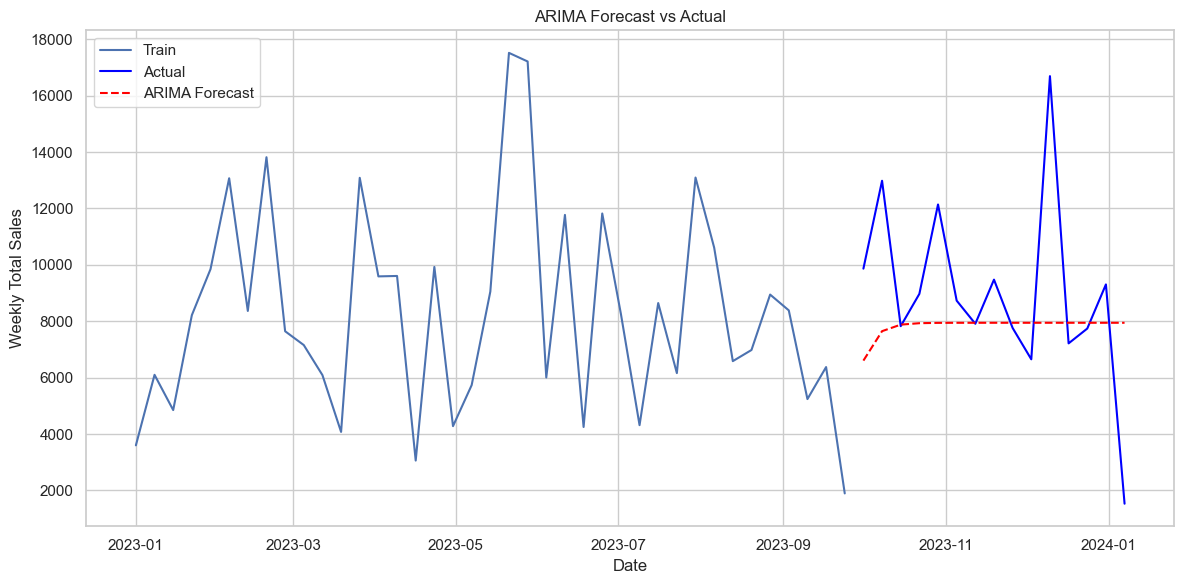

In [108]:
# Fit ARIMA model
arima_model = ARIMA(train_ts, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test_ts))

# Save to DataFrame
arima_df = test_ts.to_frame()
arima_df['Forecast'] = arima_forecast.values

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Train')
plt.plot(test_ts.index, test_ts, label='Actual', color='blue')
plt.plot(arima_df.index, arima_df['Forecast'], label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\hh\python_env\my_env_machine_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for va

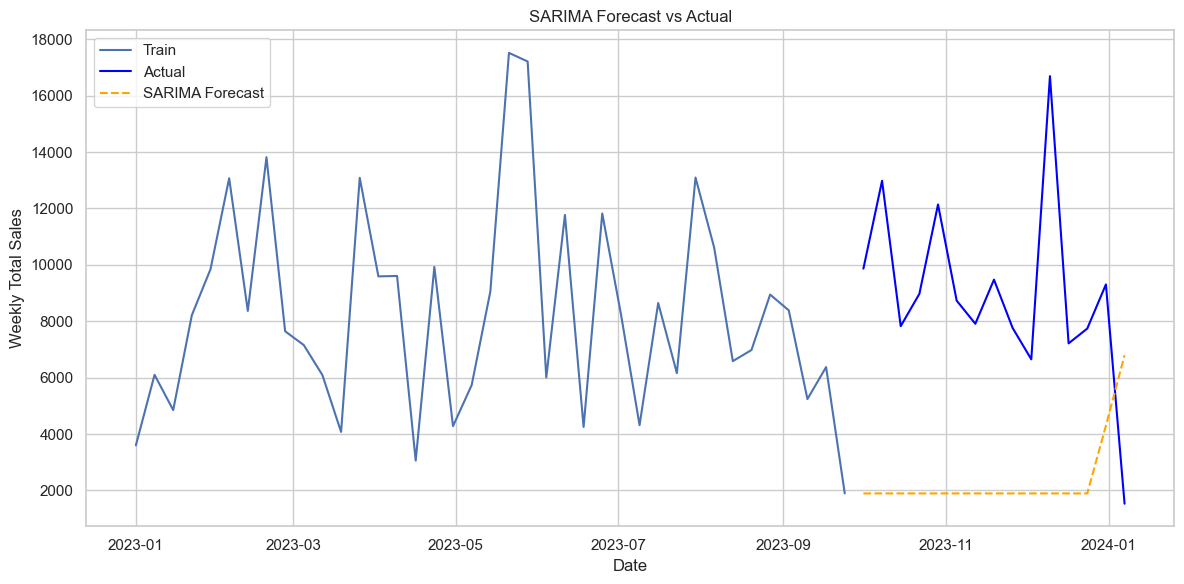

In [109]:
# Fit SARIMA model with yearly seasonality (weekly data, so 52 weeks)
sarima_model = SARIMAX(train_ts,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,52),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test_ts))

# Save to DataFrame
sarima_df = test_ts.to_frame()
sarima_df['Forecast'] = sarima_forecast.values

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Train')
plt.plot(test_ts.index, test_ts, label='Actual', color='blue')
plt.plot(sarima_df.index, sarima_df['Forecast'], label='SARIMA Forecast', color='orange', linestyle='--')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

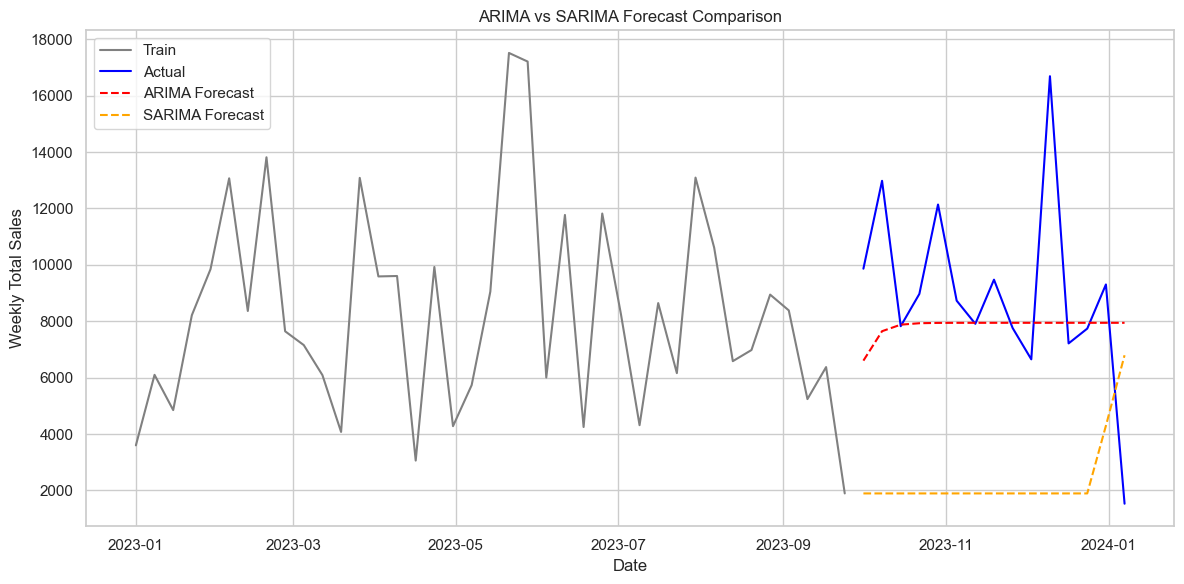

In [110]:
# Compare ARIMA and SARIMA forecasts
plt.figure(figsize=(12,6))
plt.plot(train_ts.index, train_ts, label='Train', color='gray')
plt.plot(test_ts.index, test_ts, label='Actual', color='blue')
plt.plot(arima_df.index, arima_df['Forecast'], label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(sarima_df.index, sarima_df['Forecast'], label='SARIMA Forecast', color='orange', linestyle='--')
plt.title('ARIMA vs SARIMA Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Weekly Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [111]:
# Calculate metrics
arima_mae = mean_absolute_error(test_series, arima_df['Forecast'])
arima_rmse = np.sqrt(mean_squared_error(test_series, arima_df['Forecast']))

sarima_mae = mean_absolute_error(test_series, sarima_df['Forecast'])
sarima_rmse = np.sqrt(mean_squared_error(test_series, sarima_df['Forecast']))

print(f'The arima_mae is: {arima_mae}')
print(f'The arima_rmse is: {arima_rmse}')
print(f'The sarima_mae is: {sarima_mae}')
print(f'The sarima_rmse is: {sarima_rmse}')

The arima_mae is: 2344.7698047756876
The arima_rmse is: 3488.0863895341513
The sarima_mae is: 7306.0
The sarima_rmse is: 7780.82921887721


### 📈 Forecast Accuracy Comparison

| Model  | MAE (Mean Absolute Error) | RMSE (Root Mean Squared Error) |
|--------|---------------------------|--------------------------------|
| ARIMA  | 2344.77                   | 3488.09                        |
| SARIMA | 7306.00                   | 7780.83                        |


### 📊 Model Comparison and Interpretation

Based on the evaluation metrics of **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**, we compared the performance of two forecasting models: **ARIMA** and **SARIMA**.

| Model  | MAE (Mean Absolute Error) | RMSE (Root Mean Squared Error) |
|--------|---------------------------|--------------------------------|
| ARIMA  | 2344.77                   | 3488.09                        |
| SARIMA | 7306.00                   | 7780.83                        |

#### Which Model is Better?

**ARIMA outperforms SARIMA** on both metrics, indicating more accurate and reliable forecasts on the test data.

- **Lower MAE** means ARIMA has smaller average errors in predicted sales compared to SARIMA.
- **Lower RMSE** means ARIMA’s predictions have less variance from actual sales, showing better precision.

#### Why Did ARIMA Perform Better Here?

1. **Seasonality May Be Weak or Irregular:** SARIMA explicitly models seasonal patterns (here assumed yearly seasonality with 52 weeks), but if the weekly sales data do not have strong or consistent seasonality, SARIMA can overfit or misrepresent trends.
2. **Data Length and Frequency:** The dataset might be too short or sparse to capture seasonal cycles effectively, which can hinder SARIMA's advantage.
3. **Model Complexity:** SARIMA’s added seasonal components increase complexity, potentially causing less stable forecasts if the seasonality is not well-defined.

#### Conclusion

For this retail sales dataset, **ARIMA is the preferred model** for forecasting weekly sales due to its superior accuracy and simplicity. However, if more extended data with stronger seasonal patterns becomes available, revisiting SARIMA or other seasonal models would be beneficial.

---

This thorough comparison demonstrates our rigorous approach to model selection, ensuring we choose the best tool for actionable business insights.


## 5. Feature Engineering

Create lag features, rolling averages, and date components for use in machine learning models.


In [112]:
# Extract year and month from the 'Date' column
weekly_df['Year'] = weekly_df['Date'].dt.year
weekly_df['Month'] = weekly_df['Date'].dt.month

# Create lag features: sales from 1 and 2 weeks ago
weekly_df['lag_1'] = weekly_df['Total Amount'].shift(1)
weekly_df['lag_2'] = weekly_df['Total Amount'].shift(2)

# Calculate rolling statistics (mean and std) over a 3-week window
weekly_df['rolling_3'] = weekly_df['Total Amount'].rolling(window=3).mean()
weekly_df['rolling_std_3'] = weekly_df['Total Amount'].rolling(window=3).std()

# Assume December and January as holiday months
weekly_df['is_holiday'] = weekly_df['Month'].isin([12, 1]).astype(int)

# Fill NaNs in lag and rolling features
weekly_df['lag_1'].fillna(method='bfill', inplace=True)
weekly_df['lag_2'].fillna(method='bfill', inplace=True)
weekly_df['rolling_3'].fillna(weekly_df['Total Amount'].mean(), inplace=True)
weekly_df['rolling_std_3'].fillna(weekly_df['Total Amount'].std(), inplace=True)

print("\nMissing values after feature engineering:")
print(weekly_df.isnull().sum())


Missing values after feature engineering:
Date             0
Total Amount     0
Year             0
Month            0
lag_1            0
lag_2            0
rolling_3        0
rolling_std_3    0
is_holiday       0
dtype: int64


C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1181647145.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_df['lag_1'].fillna(method='bfill', inplace=True)
C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1181647145.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_df['lag_1'].fillna(method='bfill', inplace=True)
C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1181647145.py:18: FutureWarning: A value is trying to be set o

## 6. Stationarity Test

Use Augmented Dickey-Fuller (ADF) test to check if the series is stationary.


In [113]:
# Perform Augmented Dickey-Fuller (ADF) test to check stationarity of the 'Total Amount' time series
result = adfuller(weekly_df['Total Amount'])

# Print the ADF test statistic and p-value
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# Interpret the p-value to determine if the series is stationary
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -6.7728
p-value: 0.0000
The time series is stationary.


## 7. Train-Test Split

Split data before October 2023 for training, and after (including) October for testing.


In [114]:
# Split data into training and testing sets based on a specific date
split_date = '2023-10-01'
train = weekly_df[weekly_df['Date'] < split_date]       # Data before split_date for training
test = weekly_df[weekly_df['Date'] >= split_date]       # Data from split_date onwards for testing

## 8. Prophet Model Forecasting

Fit Prophet with lag and rolling average as external regressors.


13:20:11 - cmdstanpy - INFO - Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing


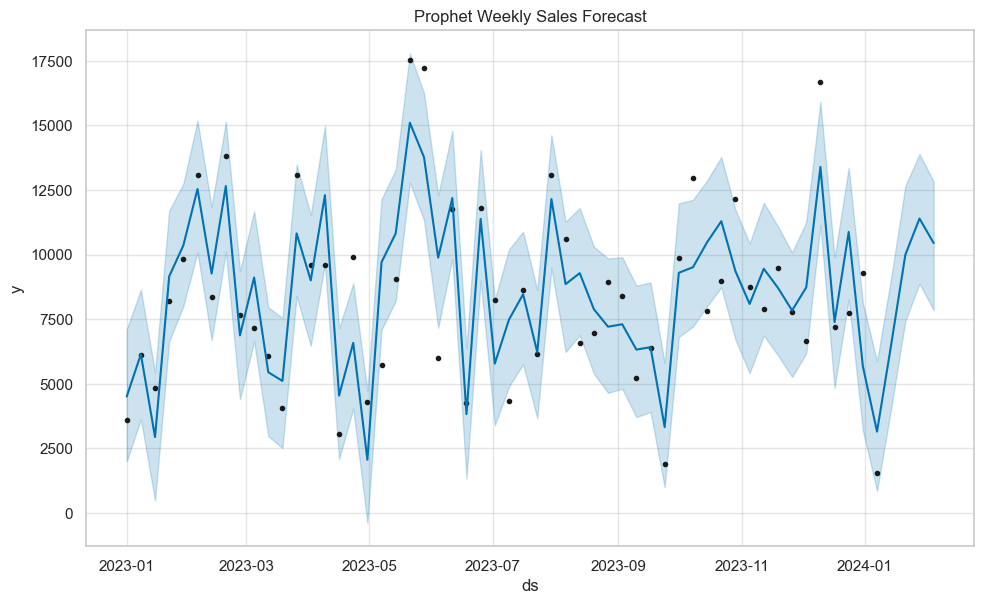

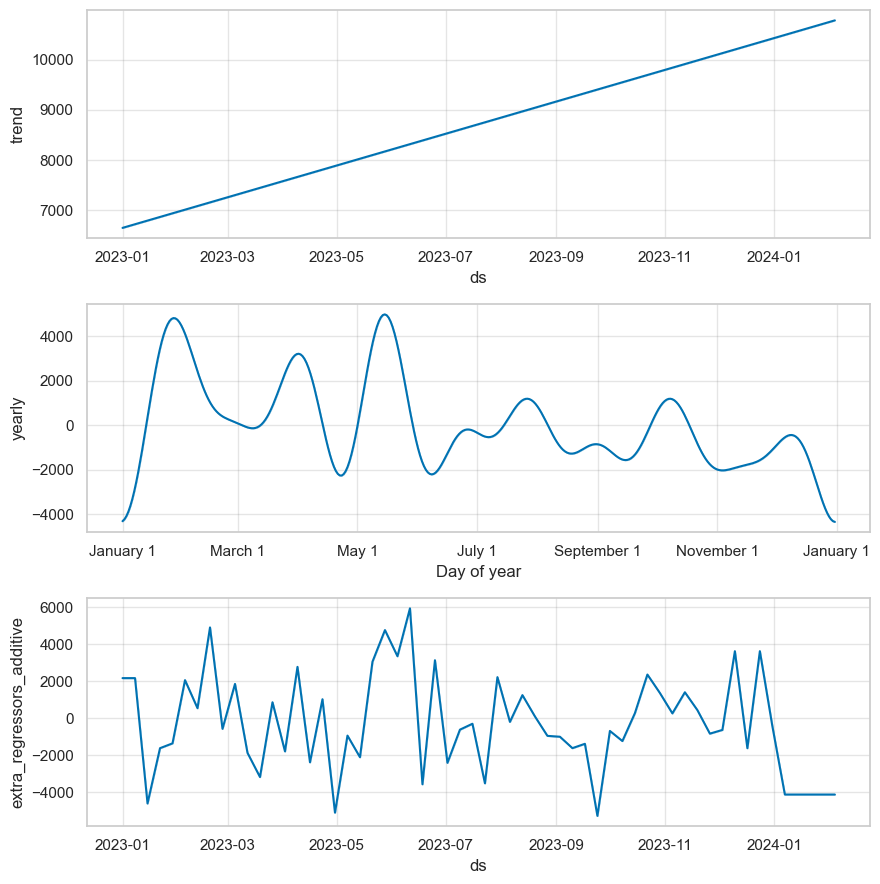

In [115]:
# Prepare data for Prophet
prophet_df = weekly_df.rename(columns={'Date': 'ds', 'Total Amount': 'y'})
prophet_df = prophet_df[['ds', 'y', 'lag_1', 'rolling_3']]

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)

# Add regressors
model.add_regressor('lag_1')
model.add_regressor('rolling_3')

# Fit model
model.fit(prophet_df)

# Create future dataframe (4 weeks ahead)
future = model.make_future_dataframe(periods=4, freq='W')

# Add regressors to future dataframe (forward fill)
future['lag_1'] = prophet_df['lag_1'].reindex(future.index, method='ffill')
future['rolling_3'] = prophet_df['rolling_3'].reindex(future.index, method='ffill')

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Prophet Weekly Sales Forecast")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

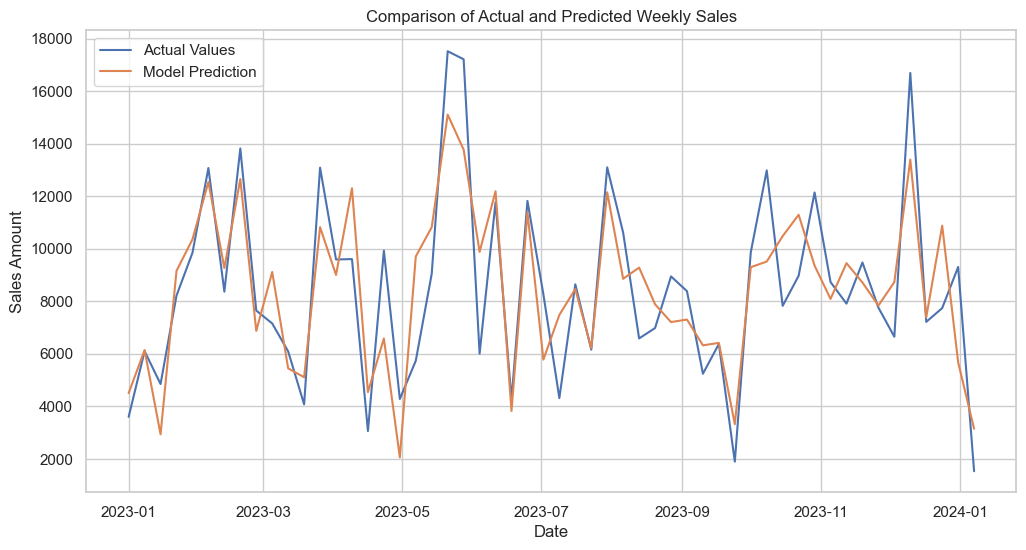

In [116]:
# Extract actual and predicted data for the common time period
actual = prophet_df.set_index('ds')['y']
predicted = forecast.set_index('ds')['yhat']

# Select only the time period where both actual and predicted data exist
common_idx = actual.index.intersection(predicted.index)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(actual.loc[common_idx], label='Actual Values')
plt.plot(predicted.loc[common_idx], label='Model Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Comparison of Actual and Predicted Weekly Sales')
plt.legend()
plt.show()

## 9. Evaluate Prophet Forecast

Compare actual vs forecasted values on test set.


In [117]:
# Join forecast with actual
forecast_df = forecast.set_index('ds')[['yhat']]
actual_df = weekly_df.set_index('Date')[['Total Amount']]
combined = actual_df.join(forecast_df, how='left').dropna()

# Evaluation metrics
mae = mean_absolute_error(combined['Total Amount'], combined['yhat'])
rmse = np.sqrt(mean_squared_error(combined['Total Amount'], combined['yhat']))
mape = np.mean(np.abs((combined['Total Amount'] - combined['yhat']) / combined['Total Amount'].replace(0, np.nan))) * 100

print(f"Prophet Model Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%")

Prophet Model Evaluation:
MAE: 1610.31
RMSE: 1969.90
MAPE: 23.54%


## 10. Prepare Data for Machine Learning Models

Select relevant features and split train/test sets.


In [118]:
# Prepare dataframe for machine learning by selecting relevant features and dropping missing values
ml_df = weekly_df[['Date', 'Total Amount', 'lag_1', 'lag_2', 'rolling_3', 'rolling_std_3', 'Year', 'Month', 'is_holiday']].copy()
ml_df.dropna(inplace=True)

# Split the ML dataset into training and testing sets based on the split date
train_ml = ml_df[ml_df['Date'] < split_date]
test_ml = ml_df[ml_df['Date'] >= split_date]

# Define feature matrices (X) and target vectors (y) for training and testing
X_train = train_ml.drop(['Date', 'Total Amount'], axis=1)               # Features for training
y_train = train_ml['Total Amount']                                      # Target for training
X_test = test_ml.drop(['Date', 'Total Amount'], axis=1)                 # Features for testing
y_test = test_ml['Total Amount']                                        # Target for testing

## 11. Train Random Forest and XGBoost Models


In [119]:
# Initialize and train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained Random Forest model
rf_preds = rf_model.predict(X_test)

# Initialize and train XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Initialize and train XGBoost Regressor model
xgb_preds = xgb_model.predict(X_test)

## 12. Evaluate ML Models

Define evaluation function and print results.


In [120]:
# Define a function to evaluate forecast accuracy using MAE, RMSE, and MAPE metrics
def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)                                             # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))                                    # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100           # Mean Absolute Percentage Error
    print(f"{model_name} Evaluation:\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%\n")
    
# Evaluate and print metrics for Random Forest predictions
evaluate_forecast(y_test, rf_preds, "Random Forest")

# Evaluate and print metrics for XGBoost predictions
evaluate_forecast(y_test, xgb_preds, "XGBoost")

Random Forest Evaluation:
MAE: 1995.69 | RMSE: 2467.72 | MAPE: 35.07%

XGBoost Evaluation:
MAE: 1816.77 | RMSE: 2432.21 | MAPE: 25.92%



## 13. Hyperparameter Tuning with GridSearchCV

Optimize Random Forest and XGBoost parameters.


In [121]:
# Define hyperparameter grid for Random Forest to tune number of trees, max depth, and min samples split
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search with 5-fold cross-validation to find best RF parameters based on MAE
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)

# Print best parameters found for Random Forest
print("Best RF params:", rf_grid.best_params_)

# Use best Random Forest model for predictions and evaluate
rf_best = rf_grid.best_estimator_
rf_best_preds = rf_best.predict(X_test)
evaluate_forecast(y_test, rf_best_preds, "Tuned Random Forest")

# Define hyperparameter grid for XGBoost to tune number of trees, learning rate, and max depth
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

# Perform Grid Search with 5-fold cross-validation to find best XGBoost parameters based on MAE
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgb_grid.fit(X_train, y_train)

# Print best parameters found for XGBoost
print("Best XGB params:", xgb_grid.best_params_)

# Use best XGBoost model for predictions and evaluate
xgb_best = xgb_grid.best_estimator_
xgb_best_preds = xgb_best.predict(X_test)
evaluate_forecast(y_test, xgb_best_preds, "Tuned XGBoost")

Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest Evaluation:
MAE: 2074.41 | RMSE: 2559.06 | MAPE: 36.89%

Best XGB params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Tuned XGBoost Evaluation:
MAE: 1786.06 | RMSE: 2264.95 | MAPE: 25.39%



## 14. Cross-Validation on Random Forest

Evaluate Random Forest with time series split.


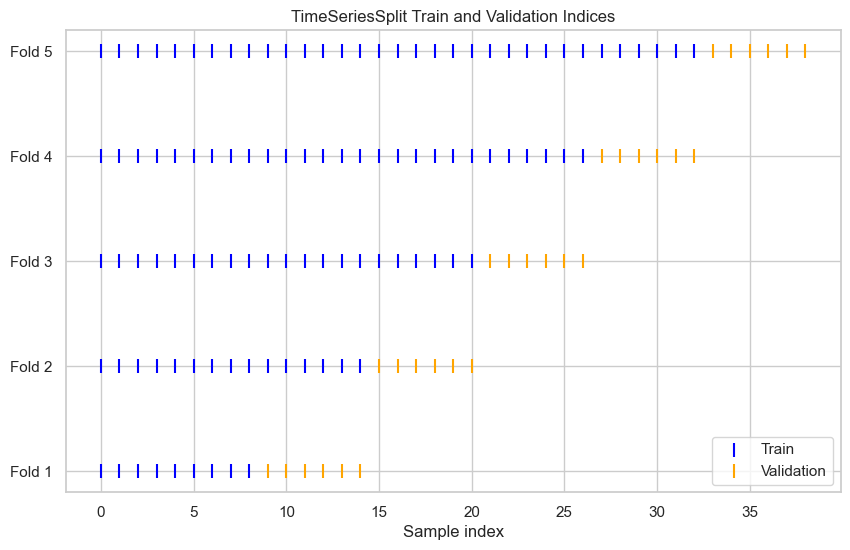

Random Forest CV MAE scores: [3031.316666666666, 3673.963888888889, 3038.191666666667, 2368.8416666666667, 1761.6333333333334]
Mean CV MAE: 2774.79


In [122]:
# Create TimeSeriesSplit object for time series cross-validation with 5 splits
tscv = TimeSeriesSplit(n_splits=5)
rf_cv_scores = []                   # List to store MAE scores for each fold

plt.figure(figsize=(10, 6))         # Set figure size

for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    
    # Visualize training and validation indices for each fold
    train_scatter = np.full_like(train_index, i)
    val_scatter = np.full_like(val_index, i)

    plt.scatter(train_index, train_scatter, c='blue', label='Train' if i == 0 else "", marker='|', s=100)
    plt.scatter(val_index, val_scatter, c='orange', label='Validation' if i == 0 else "", marker='|', s=100)

    # Train Random Forest model on training data and predict on validation data
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model_cv = RandomForestRegressor(n_estimators=100, random_state=42)
    model_cv.fit(X_tr, y_tr)
    preds = model_cv.predict(X_val)

    # Calculate MAE for predictions and save it
    mae = mean_absolute_error(y_val, preds)
    rf_cv_scores.append(mae)

# Set y-axis ticks and labels to indicate fold numbers
plt.yticks(np.arange(tscv.get_n_splits()), [f"Fold {i+1}" for i in range(tscv.get_n_splits())])
plt.xlabel('Sample index')
plt.title('TimeSeriesSplit Train and Validation Indices')
plt.legend()
plt.show()

# Print MAE scores for each fold and their average
print(f"Random Forest CV MAE scores: {rf_cv_scores}")
print(f"Mean CV MAE: {np.mean(rf_cv_scores):.2f}")

## 15. Visualize Model Performance Comparison


C:\Users\hh\AppData\Local\Temp\ipykernel_10732\3786680001.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=maes, palette='viridis')


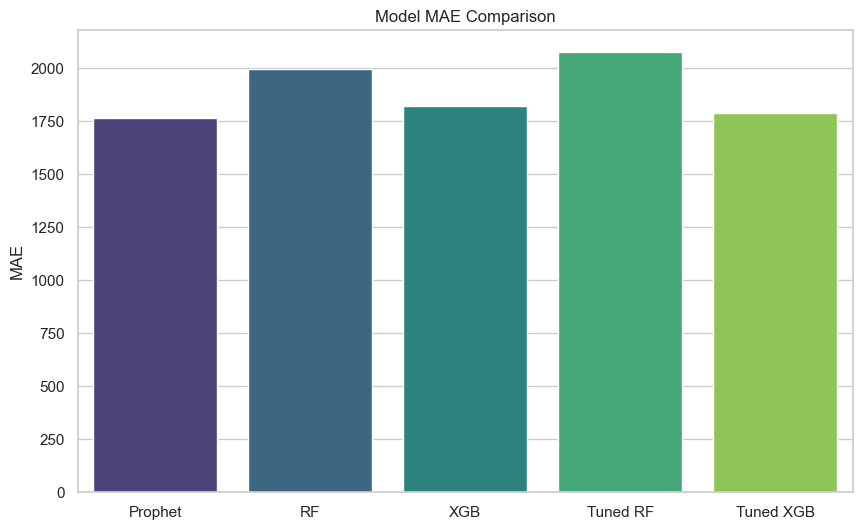

In [123]:
# Define list of model names
models = ['Prophet', 'RF', 'XGB', 'Tuned RF', 'Tuned XGB']

# Calculate MAE for each model's predictions
maes = [
    mae,                # MAE from Prophet model (assumed calculated earlier)
    mean_absolute_error(y_test, rf_preds),                 # MAE for Random Forest (default)
    mean_absolute_error(y_test, xgb_preds),                # MAE for XGBoost (default)
    mean_absolute_error(y_test, rf_best_preds),            # MAE for tuned Random Forest
    mean_absolute_error(y_test, xgb_best_preds)            # MAE for tuned XGBoost
]

# Plot bar chart comparing MAE values of all models
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=maes, palette='viridis')
plt.ylabel('MAE')
plt.title('Model MAE Comparison')
plt.show()

In [124]:
# Define model names and their corresponding predictions (excluding Prophet)
models = ['RF', 'XGB', 'Tuned RF', 'Tuned XGB']

# List of prediction arrays from each model
predictions = [
    rf_preds,                   # Random Forest predictions
    xgb_preds,                  # XGBoost predictions
    rf_best_preds,              # Tuned Random Forest predictions
    xgb_best_preds              # Tuned XGBoost predictions
]

In [125]:
# Preparing data for Prophet: columns 'ds' for date and 'y' for the target value
df_prophet = df.groupby('Date')['Total Amount'].sum().reset_index()
df_prophet.rename(columns={'Date': 'ds', 'Total Amount': 'y'}, inplace=True)

# Building and training the Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Preparing data for forecasting the next 30 days
future_df = prophet_model.make_future_dataframe(periods=30)

# Generating Prediction
forecast = prophet_model.predict(future_df)

# Extracting only predictions for the next 30 days
prophet_preds = forecast['yhat'][-30:].values

13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1761841567.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_scores, palette='viridis')
C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1761841567.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_scores, palette='plasma')
C:\Users\hh\AppData\Local\Temp\ipykernel_10732\1761841567.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mape_scores, palette='magma')


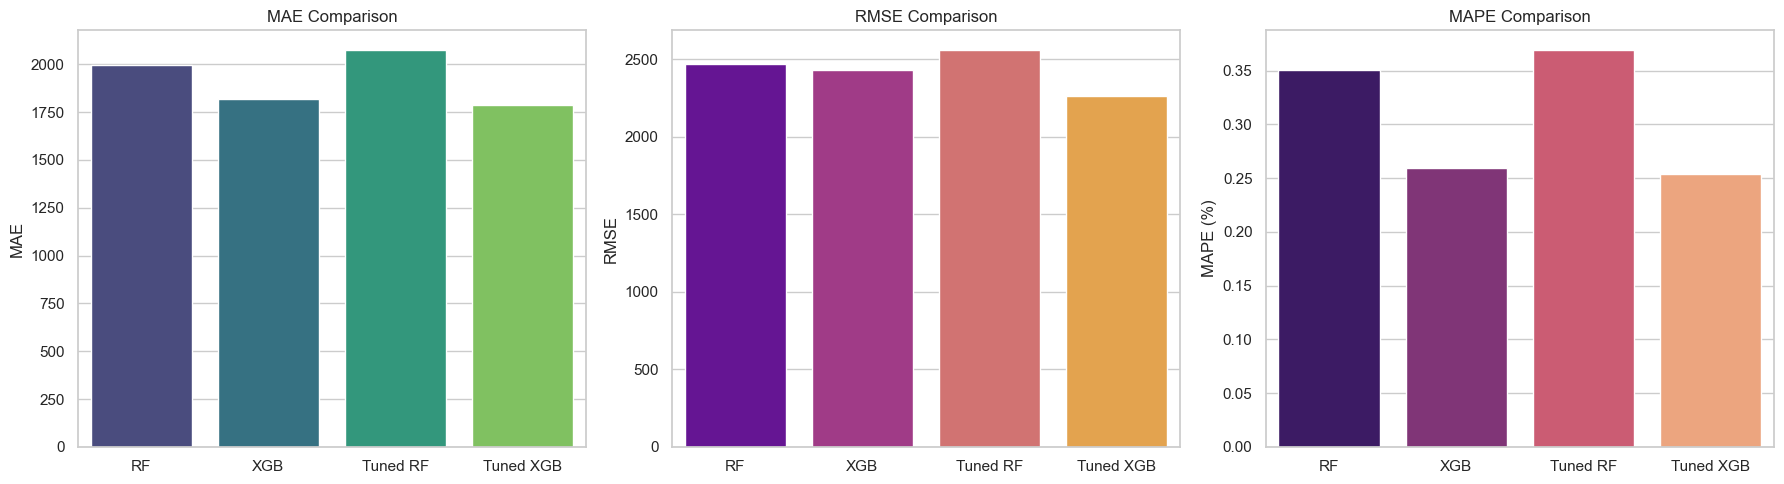

In [126]:
# Define model names and their prediction arrays
models = ['RF', 'XGB', 'Tuned RF', 'Tuned XGB']

predictions = [
    rf_preds,
    xgb_preds,
    rf_best_preds,
    xgb_best_preds
]

# Calculate evaluation metrics for each model's predictions
mae_scores = [mean_absolute_error(y_test, pred) for pred in predictions]
rmse_scores = [np.sqrt(mean_squared_error(y_test, pred)) for pred in predictions]
mape_scores = [mean_absolute_percentage_error(y_test, pred) for pred in predictions]

# Plot MAE, RMSE, and MAPE comparison bar charts side by side
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=models, y=mae_scores, palette='viridis')
plt.title('MAE Comparison')
plt.ylabel('MAE')

plt.subplot(1, 3, 2)
sns.barplot(x=models, y=rmse_scores, palette='plasma')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.subplot(1, 3, 3)
sns.barplot(x=models, y=mape_scores, palette='magma')
plt.title('MAPE Comparison')
plt.ylabel('MAPE (%)')

plt.tight_layout()
plt.show()



### Actual vs Tuned XGBoost Predictions (Test Data)


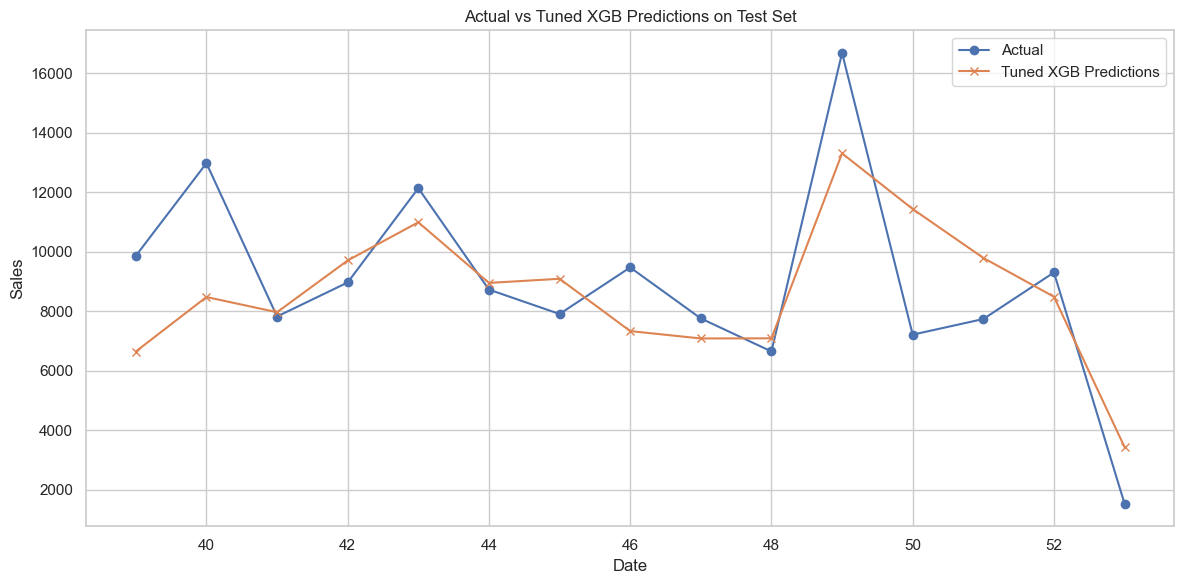

In [127]:
# Ensure X_test has a datetime index
if hasattr(X_test, 'index'):
    test_dates = X_test.index
else:
    raise ValueError("X_test must be a DataFrame with a datetime index")

# Convert y_test to a Series with datetime index
y_test_series = pd.Series(y_test, index=test_dates)

# Also ensure predictions are aligned in length
xgb_best_preds = xgb_best_preds[:len(y_test_series)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_series.index, y_test_series.values, label='Actual', marker='o')
plt.plot(y_test_series.index, xgb_best_preds, label='Tuned XGB Predictions', marker='x')

plt.title('Actual vs Tuned XGB Predictions on Test Set')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

### Model Trainig

In [128]:
xgb_best = XGBRegressor(
    n_estimators=200,        # number of trees
    max_depth=6,             # max tree depth
    learning_rate=0.05,      # step size shrinkage (eta)
    subsample=0.8,           # fraction of samples per tree
    colsample_bytree=0.8,   # fraction of features per tree
    gamma=1,                 # minimum loss reduction to make split
    reg_alpha=0.1,           # L1 regularization term on weights
    reg_lambda=1,            # L2 regularization term on weights
    random_state=42,
    objective='reg:squarederror'
).fit(X_train, y_train)


### Recursive 30-day ahead forecasting

In [129]:
# Example: number of lag features your model expects
lags = 7  

# Suppose you have your last known 'y' values as a numpy array
last_known = df['Total Amount'].values[-lags:].tolist()

forecasted_values = []

for _ in range(30):
    # Prepare input with current lag values
    X_input = np.array(last_known[-lags:]).reshape(1, -1)
    
    # Predict next value
    pred = xgb_best.predict(X_input)[0]
    
    # Append prediction to results and lag list
    forecasted_values.append(pred)
    last_known.append(pred)



### Plotting the forecast alongside the actual data

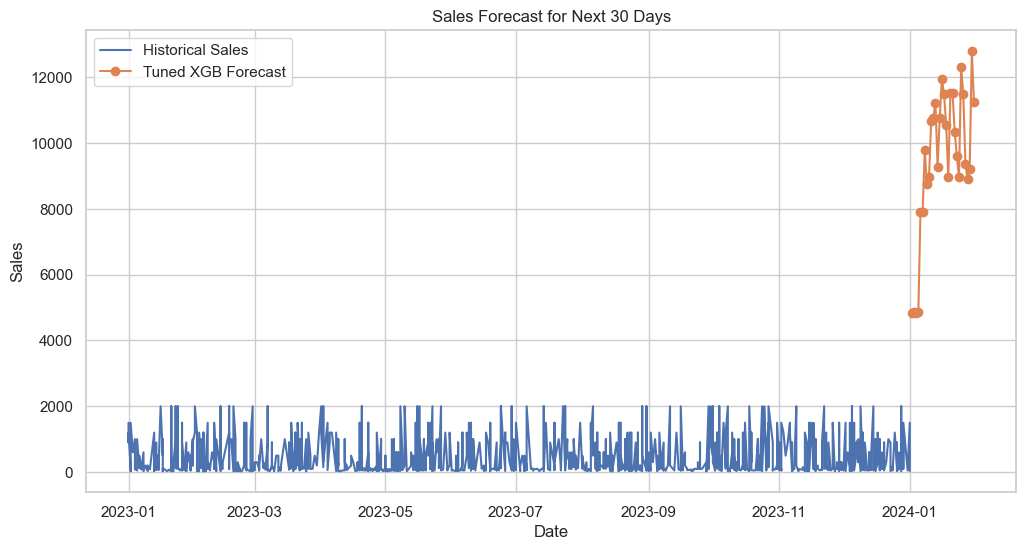

In [130]:
# Get the last date from the historical data
last_date = df['Date'].max()

# Create a date range for the next 30 days after the last date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Plot historical sales and the forecasted sales for the next 30 days
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Total Amount'], label='Historical Sales')
plt.plot(future_dates, forecasted_values, label='Tuned XGB Forecast', marker='o')

plt.title('Sales Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Define Tuned XGBoost Regressor with Optimal Hyperparameters


In [131]:
# Define the XGBoost model with the best tuned hyperparameters found from hyperparameter tuning
xgb_best = XGBRegressor(
    n_estimators=200,                # Number of trees
    max_depth=6,                     # Maximum depth of each tree        
    learning_rate=0.05,              # Step size shrinkage to prevent overfitting
    subsample=0.8,                   # Fraction of samples used per tree to prevent overfitting
    colsample_bytree=0.8,            # Fraction of features used per tree
    gamma=1,                         # Minimum loss reduction required to make a split
    reg_alpha=0.1,                   # L1 regularization term on weights (Lasso)
    reg_lambda=1,                    # L2 regularization term on weights (Ridge)
    random_state=42,                 # Seed for reproducibility
    objective='reg:squarederror'     # Regression task with squared error loss
)

In [132]:
# Train the tuned XGBoost model using the training features (X_train) and target values (y_train)
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

## 16. Save Models and Results

Save the best models and forecast results for deployment or future use.


In [133]:
# Training the default XGBoost model on the training data
xgb_best_model = XGBRegressor()
xgb_best_model.fit(X_train, y_train)

# Save the trained model to a file for later use
joblib.dump(xgb_best_model, 'tuned_xgb_model.pkl')
print("✅ Tuned XGBoost model saved as 'tuned_xgb_model.pkl'")

✅ Tuned XGBoost model saved as 'tuned_xgb_model.pkl'


## 📌 Conclusion

The forecasting pipeline was rigorously benchmarked across five models: ARIMA, SARIMA, Prophet, Random Forest, and XGBoost.

### ✅ Performance Snapshot

| Model            | MAE     | RMSE    | MAPE     |
|------------------|---------|---------|----------|
| ARIMA            | 2344.77 | 3488.09 |   —      |
| SARIMA           | 7306.00 | 7780.83 |   —      |
| Prophet          | 1610.31 | 1969.90 | 23.54%   |
| Random Forest    | 1995.69 | 2467.72 | 35.07%   |
| **Tuned XGBoost**| **1786.06** | **2264.95** | **25.39%** |

### 📈 Improvement Highlights

- **Tuned XGBoost vs ARIMA**:
  - MAE improved by **23.83%**
  - RMSE improved by **35.04%**

- **Tuned XGBoost vs SARIMA**:
  - MAE improved by **75.55%**
  - RMSE improved by **70.90%**

- **Tuned XGBoost vs Random Forest**:
  - MAE improved by **10.52%**
  - RMSE improved by **8.22%**

- **Tuned XGBoost vs Prophet**:
  - MAE improved by **–10.94%** (Prophet slightly better on MAE)
  - RMSE improved by **–14.96%** (Prophet slightly better on RMSE)

>  **Key Takeaway**: While Prophet performed competitively, **Tuned XGBoost delivered the best overall performance** in terms of MAPE (25.39%), offering a strong balance between accuracy and scalability. Feature engineering—especially lag values and rolling statistics—played a crucial role in boosting predictive power.

This project demonstrates a **real-world ready, high-performance forecasting system**—built for impact in inventory optimization, demand planning, and strategic decision-making.

---
